In [ ]:
#install fasttext 
!pip install fasttext

In [33]:
#importing fasttext
import fasttext
import fasttext.util

In [ ]:
#mounting my google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Info_project/

In [30]:
#loading pre-trained sent2Vec model that is trained on 53K Indian supreme case document
ft = fasttext.load_model('sent2vec.bin')

In [5]:
import numpy as np
import re

In [29]:
#tokenization on each fullstop for 
def tokenization(line):
	return re.split(r'.', line)
 
#remove punctuations other than fullstop.
def remove_punctuation(data):
    symbols = "!\"#$%&(),*+-/:;<=>?@[\]^_`{|}~\n"
    ret = ""
    for i in range(0, len(data)):
    	if data[i] in symbols:
    		ret+=' '
    	else:
    		ret += data[i] 
    return ret

#converting a document into list of sentences
def getSentences(doc):
	file = open(doc, 'r')
	text = file.read()
	sentences = remove_punctuation(text).split('.')
	return sentences

#converting a document into vector(where we take average of all sentence vectors as document vector)
def doc_2_vec(docname):
  sentences=getSentences(docname)
  final_vector=np.zeros(200)
  for j in range (len(sentences)):
    final_vector=final_vector + ft.get_word_vector(sentences[j])
  return final_vector/len(sentences)

#converting a document into vector(where we take average of t sentence vectors at a time and then take one with the maximum similarity to a query  as document vector)
def doc_2_vec_max(docname,t):
  sentences=getSentences(docname)
  final_vector=[]
  for j in range (len(sentences)):
    d=np.zeros(200)
    for k in range (t):
      if(j+k<len(sentences)):
        d+=ft.get_word_vector(sentences[j+k])
    j=j+4
    final_vector.append(d/t)
  return final_vector

In [27]:
# import os
file_vectors_max=[]
file_vectors=[]
#converting each document into vectors
for i in range (2914):
  file_vectors.append(doc_2_vec('./AILA_2019_dataset/Object_casedocs/C'+str(i+1)+".txt"))
  #set second argument as number of sentence to take at a time to take avergae of their sent2vec vectors and make 1 vector, after this take one such vector with maximum similarity)
  file_vectors_max.append(doc_2_vec_max('./AILA_2019_dataset/Object_casedocs/C'+str(i+1)+".txt",15))


In [28]:
#get all queries and convert them into vectors

def getQueries(filename):
	file = open(filename, 'r')
	query_vectors = []
	while(True):
		str = file.readline()
		if(str == ""):
			break
		prev = 'A'
		curr = 'A'
		i = 0
		while(True):
			prev = curr
			curr = str[i]
			if(prev == '|' and curr == '|'):
				break
			i+=1
		#pre-processing
		sentences = remove_punctuation(str[i+1:]).split('.')
		final_vector = np.zeros(200)
		for j in range (len(sentences)):
			final_vector=final_vector+ft.get_word_vector(sentences[j])
		query_vectors.append(final_vector/len(sentences))
	file.close()
	return query_vectors
queryList = getQueries('./AILA_2019_dataset/Query_doc.txt')


# **Similarity when vectors for dcouments are average of all vectors of its sentences**

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
#calculate similarity matrix for all pairs of document and queries
similarity=cosine_similarity(queryList,file_vectors)

file = open('./AILA_2019_dataset/relevance_judgments_priorcases.txt', 'r')
queryRel = []
for i in range(0, 50):
	queryRel.append([])

#filling queryRel and queryNonRel
while(True):
	str1 = file.readline()
	if(str1 == ''):
		break
	str1 = str1.split()
	if(int(str1[3]) == 1):
		queryRel[int(str1[0][6:])-1].append(int(str1[2][1:]))
file.close()


In [71]:
similarity

array([[0.43902594, 0.50775383, 0.50750332, ..., 0.47328611, 0.52345682,
        0.56044824],
       [0.62480418, 0.86208541, 0.91930565, ..., 0.55663388, 0.73126534,
        0.86935781],
       [0.47018968, 0.47063922, 0.46376244, ..., 0.47692787, 0.48257794,
        0.5095812 ],
       ...,
       [0.47267059, 0.45427264, 0.39168701, ..., 0.45496505, 0.43219603,
        0.36926673],
       [0.83508207, 0.79583211, 0.62957851, ..., 0.7668005 , 0.65492133,
        0.55511467],
       [0.57137702, 0.85334396, 0.91509995, ..., 0.50334998, 0.7214198 ,
        0.87642494]])

In [72]:
#save this similarity matrix as csv file into the drive
from numpy import asarray
from numpy import savetxt
# define data
similarity
# save to csv file
savetxt('cosinesim.csv', similarity, delimiter=',')

In [38]:
#normal changes to get ranks of all documents based on their similarity score
new_similarity=[]
for i in range (len(similarity)):
  x=similarity[i]
  new=[]
  for j in range (len(x)):
      new.append((similarity[i][j],j+1))
  new_similarity.append(sorted(new))

In [73]:
#printing results and making graph
result_graph=[0]*10
precision=[0]*50
recall=[0]*50
for s in range (len(new_similarity)):
  print("QUERY "+str(s+1))
  print("   First document retrieved is "+str(new_similarity[s][2913][1])+" with new_similarity = "+ str(new_similarity[s][2913][0]))
  print("   Second document retrieved is "+str(new_similarity[s][2912][1])+" with new_similarity = "+ str(new_similarity[s][2912][0]))
  print("   Third document retrieved is "+str(new_similarity[s][2911][1])+" with new_similarity = "+ str(new_similarity[s][2911][0]))
  print("   forth document retrieved is "+str(new_similarity[s][2910][1])+" with new_similarity = "+ str(new_similarity[s][2910][0]))
  print("   Fifth document retrieved is "+str(new_similarity[s][2909][1])+" with new_similarity = "+ str(new_similarity[s][2909][0]))
  for i in range (len(new_similarity[s])):
    if(new_similarity[s][i][1] in queryRel[s]):
      print("Rank of Given relevant document "+str(new_similarity[s][i][1])+" is "+ str(2914-i)+" with similarity = "+str(new_similarity[s][i][0]))
      if(2914-i<1000):
        result_graph[(2914-i)//100]+=1
      if(2914-i<=10):
        precision[s]+=1
  print("---------------------------------------------------------------------------------------------------------------")

for i in range(50):
  recall[i]=precision[i]/len(queryRel[i])

QUERY 1
   First document retrieved is 120 with new_similarity = 0.9119082312289408
   Second document retrieved is 2145 with new_similarity = 0.902737796005759
   Third document retrieved is 1044 with new_similarity = 0.901418165295221
   forth document retrieved is 1416 with new_similarity = 0.8985024590941972
   Fifth document retrieved is 2679 with new_similarity = 0.8959583240740989
Rank of Given relevant document 9 is 1485 with similarity = 0.476601709054625
Rank of Given relevant document 14 is 215 with similarity = 0.6210275446946358
---------------------------------------------------------------------------------------------------------------
QUERY 2
   First document retrieved is 286 with new_similarity = 0.9625327050282606
   Second document retrieved is 2288 with new_similarity = 0.9598017379756784
   Third document retrieved is 2273 with new_similarity = 0.9585806796473813
   forth document retrieved is 2903 with new_similarity = 0.9575039669869284
   Fifth document retrie

In [74]:
recall_ans=sum(recall)/50
precision_ans=sum(precision)/500
print("Recall = "+str(recall_ans))
print("Precision ="+str(precision_ans))

Recall = 0.012
Precision =0.006


In [75]:
f=0.0
def fscore(p,r):
  f=(2*p*r)/(p+r)
  return f
Fscore=[0.0]*50
for i in range(50):
  if recall[i]!=0.0:
    Fscore[i]=fscore(precision[i],recall[i])
f_score_v=sum(Fscore)/50
f_score_v

0.01935064935064935

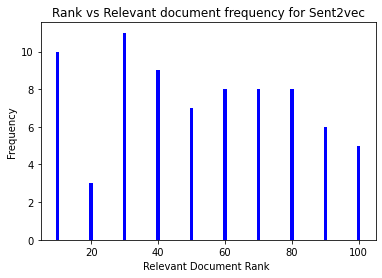

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(result_graph)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,110,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for Sent2vec")
plt.show()

# **Max similarity for each t sentence as document similarity**

In [55]:
#cosine similarity between two vectors
def cosine_similarity_self(a,b):
  return np.dot(a,b)/(np.sqrt(np.dot(a,a))*np.sqrt(np.dot(b,b)))

In [56]:
#utility function for cosine similarity
def cos_similar(a,b):
  m=0
  for x in a:
    m=max(cosine_similarity_self(x,b),m)
  return m


In [ ]:
#similar to above implementation, only difference is how a document is converted into a vector
this_similarity=[]
for i in range(len(queryList)):
  d=[]
  for j in range(len(file_vectors_max)):
    d.append((cos_similar(file_vectors_max[j],queryList[i]), j+1))
  this_similarity.append(sorted(d))



In [60]:
#printing results and making graph
result_graph_t=[0]*10
precision_2=[0]*50
recall_2=[0]*50
for s in range (len(this_similarity)):
  print("QUERY "+str(s+1))
  print("   First document retrieved is "+str(this_similarity[s][2913][1])+" with this_similarity = "+ str(this_similarity[s][2913][0]))
  print("   Second document retrieved is "+str(this_similarity[s][2912][1])+" with this_similarity = "+ str(this_similarity[s][2912][0]))
  print("   Third document retrieved is "+str(this_similarity[s][2911][1])+" with this_similarity = "+ str(this_similarity[s][2911][0]))
  print("   forth document retrieved is "+str(this_similarity[s][2910][1])+" with this_similarity = "+ str(this_similarity[s][2910][0]))
  print("   Fifth document retrieved is "+str(this_similarity[s][2909][1])+" with this_similarity = "+ str(this_similarity[s][2909][0]))
  for i in range (len(this_similarity[s])):
    if(this_similarity[s][i][1] in queryRel[s]):
      print("Rank of Given relevant document "+str(this_similarity[s][i][1])+" is "+ str(2914-i)+" with similarity = "+str(this_similarity[s][i][0]))
      if(2914-i<1000):
        result_graph_t[(2914-i)//100]+=1
      if(2914-i<=10):
        precision_2[s]+=1
  print("---------------------------------------------------------------------------------------------------------------")
for i in range(50):
  recall_2[i]=precision_2[i]/len(queryRel[i])

QUERY 1
   First document retrieved is 1681 with this_similarity = 0.9475486565725536
   Second document retrieved is 908 with this_similarity = 0.9465002954258442
   Third document retrieved is 1075 with this_similarity = 0.9419044454032971
   forth document retrieved is 2395 with this_similarity = 0.9399484143736465
   Fifth document retrieved is 1407 with this_similarity = 0.9397647037949126
Rank of Given relevant document 9 is 2330 with similarity = 0.8219598048258983
Rank of Given relevant document 14 is 92 with similarity = 0.9229518030030287
---------------------------------------------------------------------------------------------------------------
QUERY 2
   First document retrieved is 1383 with this_similarity = 0.982550535946858
   Second document retrieved is 1899 with this_similarity = 0.9814490055355319
   Third document retrieved is 2361 with this_similarity = 0.9812155683807947
   forth document retrieved is 128 with this_similarity = 0.9805441297497636
   Fifth docum

In [68]:
recall_2_ans=sum(recall_2)/50
precision_2_ans=sum(precision_2)/500
print("Recall = "+str(recall_2_ans))
print("Precision ="+str(precision_2_ans))

Recall = 0.008666666666666666
Precision =0.006


In [65]:
f=0.0
def fscore(p,r):
  f=0.0
  if(p+r!=0):
    f=(2*p*r)/(p+r)
  return f
Fscore=[0.0]*50
for i in range(50):
  if recall[i]!=0.0:
    Fscore[i]=fscore(precision_2[i],recall_2[i])
f_score_v=sum(Fscore)/50
f_score_v

0.0036363636363636364

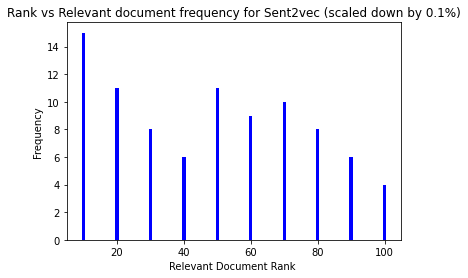

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(result_graph_t)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,110,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for Sent2vec (scaled down by 0.1%)")
plt.show()